In [1]:
#Importing useful libriaries
import scipy as sp
import numpy as np
from scipy import random
from scipy.stats import norm
import math
import matplotlib.pyplot as plt

T = 1
rf = 0.08 
S = 100 
X = 150
K = X
sigma = 0.3 

### 4.) Pricing a European call option with the information provided

In [2]:
#Code for call option
random.seed(0)

#Function for terminal share valuation
def terminal_shareprice(S, rf,sigma,Z,T):
    """Generates the terminal share price given some random normal values, Z"""
    return S*np.exp((rf-sigma**2/2)*T+sigma*np.sqrt(T)*Z)

#Function for put valuations
def discounted_call_payoff(S,K,rf,T):
    """Function for evaluating the discounted payoff of call price in Monte Carlo Estimation"""
    return np.exp(-rf*T)*np.maximum(S-K,0)

#Empty vectors to be filled later
mcall_estimates = [None]*50
mcall_std = [None]*50

#Applying MC estimation
for i in range(1,51):
    norm_array = norm.rvs(size = 1000*i)
    term_val = terminal_shareprice(S, rf,sigma,norm_array,T)
    mcall_val = discounted_call_payoff(term_val,K,rf,T)
    mcall_estimates[i-1] = np.mean(mcall_val)
    mcall_std[i-1] = np.std(mcall_val)/np.sqrt(1000*i)
    
mcall_estimates[i-1], mcall_std[i-1]

(2.4480069724273, 0.045299744960906156)

### 5.) Pricing a European up-and-out barrier call option

In [3]:
barrier = 150        # Barrier level
n_simulation = 100  # number of simulations

def bs_call(S,X,T,rf,sigma):
  
    from scipy import log,exp,sqrt,stats
    d1=(np.log(S/X)+(rf+sigma*sigma/2.)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    return S*stats.norm.cdf(d1)-X*np.exp(-rf*T)*stats.norm.cdf(d2)

def up_and_out_call(s0,x,T,r,sigma,n_simulation,barrier):
    """
        Returns: Call value of an up-and-out barrier option with European call
    """
    n_steps= 100 # Define number of steps.
    dt = T/n_steps
    total=0
    for j in range(0,n_simulation):
        sT=s0
        out=False
        for i in range(0,int(n_steps)):
            e= sp.random.normal()
            sT*=np.exp((r-0.5*sigma**2)*dt+sigma*e*np.sqrt(dt))
            if sT>barrier:
                out=True
        
        if out==False:
            total+=bs_call(s0,x,T,r,sigma)
    return total/n_simulation

### 6.) Pricing a European up-and-in barrier call option with the two other option prices.

In [4]:
result = up_and_out_call(S,K,T,rf,sigma,n_simulation,barrier)
print('Price for the Up-and-out Call = ', round(result,3))

Price for the Up-and-out Call =  2.056


### 7.) Repeat Question 5 (Price up-and-out barrier call) 6 times

In [5]:
import pandas as pd
strike_level = [85, 90, 95, 105, 110, 115]
option_price = []
for K in strike_level:
    result = up_and_out_call(S,K,T,rf,sigma,n_simulation,barrier)
    option_price.append(round(result,3))

final_result = {'Strike Level': strike_level, 'Option Price': option_price}
table = pd.DataFrame(data = final_result)   
print(table)

   Strike Level  Option Price
0            85        20.469
1            90        17.098
2            95        15.629
3           105        10.138
4           110         9.346
5           115         7.562


### 8. Estimating Credit Valuation Adjustment (CVA). 

In [7]:
#Initialization
V_0 = 200
sigma_firm = 0.25
recovery_rate = 0.25
debt = 175


#Computing the terminal value and call payoff
def terminal_value(S, rf, sigma, Z, T):
    return S*np.exp((rf-sigma**2/2)*T+sigma*np.sqrt(T)*Z)

def call_payoff(S_T,K):
    return np.maximum(S_T-K,0)

#Calculating the correlation matrix
np.random.seed(0)

corr_tested = np.linspace(-1, 1, 21)
cva_estimates = [None]*len(corr_tested)
cva_std = [None]*len(corr_tested)


#Implementing CVA in python
for i in range(len(corr_tested)):
    
    correlation = corr_tested[i]
    if (correlation == 1 or correlation == -1):
        norm_vec_0 = norm.rvs(size=50000)
        norm_vec_1 = correlation*norm_vec_0
        corr_norm_matrix = np.array([norm_vec_0, norm_vec_1])
        
    else:
        corr_matrix = np.array([[1, correlation], [correlation, 1]])
        norm_matrix = norm.rvs(size = np.array([2,50000]))
        corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)
        
    term_stock_val = terminal_value(S, rf, sigma, corr_norm_matrix[0,],T)
    call_val = call_payoff(term_stock_val, K)
    term_firm_val = terminal_value(V_0, rf, sigma_firm, corr_norm_matrix[1,],T)
    amount_lost = np.exp(-rf*T)*(1-recovery_rate)*(term_firm_val < debt)*call_val
    cva_estimates[i] = np.mean(amount_lost)
    cva_std[i] = np.std(amount_lost)/np.sqrt(50000)

    
    
#Calculating default probability
d_1 = (np.log(V_0/debt)+(rf+sigma_firm**2/2)*(T))/(sigma_firm*np.sqrt(T))
d_2 = d_1 - sigma_firm*np.sqrt(T)

default_prob = norm.cdf(-d_2)


#Calculating the analytic solution for vanilla European Call option
d_1_stock = (np.log(S/K)+(rf+sigma**2/2)*(T))/(sigma*np.sqrt(T))
d_2_stock = d_1_stock - sigma*np.sqrt(T)

analytic_callprice = S*norm.cdf(d_1_stock)-K*np.exp(-rf*T)*norm.cdf(d_2_stock)

In [8]:
uncorr_cva = (1-recovery_rate)*default_prob*analytic_callprice

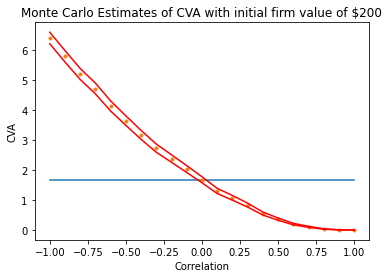

In [9]:
plt.title('Monte Carlo Estimates of CVA with initial firm value of $200')
plt.plot(corr_tested,[uncorr_cva]*21)
plt.plot(corr_tested, cva_estimates, '.')
plt.plot(corr_tested, cva_estimates+3*np.array(cva_std), 'r')
plt.plot(corr_tested, cva_estimates-3*np.array(cva_std), 'r')
plt.xlabel('Correlation')
plt.ylabel('CVA')
plt.show()

#### 9. Calculate the Monte Carlo estimates for the price of the option incorporating counterparty risk, given by the default-free price less the CVA

In [ ]:
#Initialization
V_0 = 200
sigma_firm = 0.25
recovery_rate = 0.25
debt = 175


#Computing the terminal value and call payoff
def terminal_value(S, rf, sigma, Z, T):
    return S*np.exp((rf-sigma**2/2)*T+sigma*np.sqrt(T)*Z)

def call_payoff(S_T,K):
    return np.maximum(S_T-K,0)

#Calculating the correlation matrix
np.random.seed(0)

corr_tested = np.linspace(-1, 1, 21)
cva_estimates = [None]*len(corr_tested)
cva_std = [None]*len(corr_tested)


#Implementing CVA in python
for i in range(len(corr_tested)):
    
    correlation = corr_tested[i]
    if (correlation == 1 or correlation == -1):
        norm_vec_0 = norm.rvs(size=50000)
        norm_vec_1 = correlation*norm_vec_0
        corr_norm_matrix = np.array([norm_vec_0, norm_vec_1])
        
    else:
        corr_matrix = np.array([[1, correlation], [correlation, 1]])
        norm_matrix = norm.rvs(size = np.array([2,50000]))
        corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)
        
    term_stock_val = terminal_value(S, rf, sigma, corr_norm_matrix[0,],T)
    call_val = call_payoff(term_stock_val, K)
    term_firm_val = terminal_value(V_0, rf, sigma_firm, corr_norm_matrix[1,],T)
    amount_lost = np.exp(-rf*T)*(1-recovery_rate)*(term_firm_val < debt)*call_val
    cva_estimates[i] = np.mean(amount_lost)
    cva_std[i] = np.std(amount_lost)/np.sqrt(50000)

    
    
#Calculating default probability
d_1 = (np.log(V_0/debt)+(rf+sigma_firm**2/2)*(T))/(sigma_firm*np.sqrt(T))
d_2 = d_1 - sigma_firm*np.sqrt(T)

default_prob = norm.cdf(-d_2)


#Calculating the analytic solution for vanilla European Call option
d_1_stock = (np.log(S/K)+(rf+sigma**2/2)*(T))/(sigma*np.sqrt(T))
d_2_stock = d_1_stock - sigma*np.sqrt(T)

analytic_callprice = S*norm.cdf(d_1_stock)-K*np.exp(-rf*T)*norm.cdf(d_2_stock)